In [1]:
import os
import pandas as pd 
import numpy as np

import tensorflow 
from tensorflow import keras
from keras import layers, regularizers

import cv2 #images
import psycopg2


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## import dependencies for model
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

2024-10-24 10:34:41.152189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Database connection setup

import json

with open('config.json', 'r') as config_file:
    config = json.load(config_file)

DB_HOST = config["DB_HOST"]
DB_NAME = config["DB_NAME"]
DB_USER = config["DB_USER"]
DB_PASS = config["DB_PASS"]


In [ ]:
# import pandas as pd
# import psycopg2
# from PIL import Image
# import io
# import base64

# # Connect to the database
# connection = psycopg2.connect(
#             host=DB_HOST,
#             database=DB_NAME,
#             user=DB_USER,
#             password=DB_PASS
# )

# cursor = connection.cursor()

# # Read the metadata CSV
# metadata = pd.read_csv('/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Dataset/HAM10000_metadata.csv')

# # Function to convert image to binary data
# def image_to_binary(image_path):
#     with open(image_path, 'rb') as file:
#         binary_data = file.read()
#     return binary_data

# # Base paths for the image directories
# image_dir_1 = '/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Dataset/HAM10000_images_part_1'
# image_dir_2 = '/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Dataset/HAM10000_images_part_2'

# # Insert the data into the table
# for index, row in metadata.iterrows():
#     image_id = row['image_id']
    
#     # Check which directory contains the image
#     image_path_1 = os.path.join(image_dir_1, f"{image_id}.jpg")
#     image_path_2 = os.path.join(image_dir_2, f"{image_id}.jpg")
    
#     if os.path.exists(image_path_1):
#         image_path = image_path_1
#     elif os.path.exists(image_path_2):
#         image_path = image_path_2
#     else:
#         print(f"Image {image_id} not found in either directory.")
#         continue

#     try:
#         binary_data = image_to_binary(image_path)
#         cursor.execute(
#             """
#             INSERT INTO skin_cancer_data (lesion_id, image_id, dx, dx_type, age, sex, localization, image_data)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
#             """,
#             (row['lesion_id'], row['image_id'], row['dx'], row['dx_type'],
#              row['age'], row['sex'], row['localization'], psycopg2.Binary(binary_data))
#         )
#     except Exception as e:
#         print(f"Error processing image {image_id}: {e}")

# # Commit the transaction and close the connection
# connection.commit()
# cursor.close()
# connection.close()


In [3]:
import pandas as pd
import json
from sqlalchemy import create_engine

# Load database connection parameters from config.json
def load_config():
    with open('config.json', 'r') as file:
        config = json.load(file)
    return config

# Create a SQLAlchemy engine using parameters from config
def create_engine_connection():
    config = load_config()
    DB_USER = config["DB_USER"]
    DB_PASS = config["DB_PASS"]
    DB_HOST = config["DB_HOST"]
    DB_NAME = config["DB_NAME"]
    
    engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}')
    return engine

# Function to load data from the database using SQLAlchemy engine
def load_data_from_db():
    engine = create_engine_connection()
    query = "SELECT * FROM skin_cancer_data;"
    df = pd.read_sql(query, engine)
    engine.dispose()  
    return df

# Load the data and display df
df = load_data_from_db()
print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_data  
0  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  
1  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  
2  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  
3  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  
4  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  


In [4]:
#Display df 
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_data
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."


In [5]:
# Save df 
df.to_csv('metadata_df.csv', index=False)

In [6]:
# Display info
df.info()
# Check null values
df.isnull().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   image_data    10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
image_data       0
dtype: int64

In [10]:
# Drop original categorical columns
df.drop(['dx', 'dx_type', 'sex', 'localization'], axis=1, inplace=True)


In [12]:
from PIL import Image
import io
import numpy as np
# Modify Batch size 10,015 to include entire dataset
def process_images_in_batches(df, batch_size=1015):
    total_images = len(df)
    batch = df.iloc[:batch_size]
   
    new_df = pd.DataFrame()  
    new_df['image_id'] = batch['image_id']
    new_df['image_array'] = None
    
    for idx, row in batch.iterrows():
        binary_data = row['image_data']
        with Image.open(io.BytesIO(binary_data)) as im: 
            image = im.resize((224, 224))
            image_array = np.array(image) / 255.0
            new_df['image_array'].iloc[idx]= image_array
            
    return new_df


In [13]:
# Call the function with the DataFrame
X_images = process_images_in_batches(df)
X_images.head()

/var/folders/w1/kv9m74sx7rn3jh6fkm7wrzrc0000gp/T/ipykernel_65279/509694628.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  new_df['image_array'].iloc[idx]= image_array
/var/folders/w1/kv9m74sx7rn3jh6fkm7wrzrc0000gp/T/ipykernel_65279/509

,image_id,image_array
0,ISIC_0027419,"[[[0.7333333333333333, 0.5882352941176471, 0.7..."
1,ISIC_0025030,"[[[0.09411764705882353, 0.050980392156862744, ..."
2,ISIC_0026769,"[[[0.7294117647058823, 0.4980392156862745, 0.5..."
3,ISIC_0025661,"[[[0.09019607843137255, 0.043137254901960784, ..."
4,ISIC_0031633,"[[[0.49019607843137253, 0.3254901960784314, 0...."


In [14]:
# Save the DataFrame as a CSV file
X_images.to_csv('skin_cancer_detection_array_all_images.csv', index=False)

In [15]:
X_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_id     1015 non-null   object
 1   image_array  1015 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


In [18]:
from sklearn.model_selection import train_test_split

# Define X (features) and y (target variable)
X = np.stack(merged_df['image_array'].values)  
y = merged_df['dx_encoded'].values

In [ ]:
# Ensure labels are within the range [0, num_classes - 1]
unique_labels = np.unique(y)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y = np.array([label_map[label] for label in y])


In [21]:
# Encode the labels
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

In [22]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Check shapes of the training and test sets
print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)  
print("X_test shape:", X_test.shape)    
print("y_test shape:", y_test.shape)    


X_train shape: (812, 224, 224, 3)
y_train shape: (812, 2)
X_test shape: (203, 224, 224, 3)
y_test shape: (203, 2)


In [25]:
# Verify the data types
print("X_train dtype:", X_train.dtype)  
print("y_train dtype:", y_train.dtype)  


X_train dtype: float64
y_train dtype: float64


In [26]:
# Convert one-hot encoded labels back to class indices for counting
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Check the class distribution
train_class_distribution = np.bincount(y_train_classes)
test_class_distribution = np.bincount(y_test_classes)

print("Training set class distribution:", train_class_distribution)
print("Testing set class distribution:", test_class_distribution)


Training set class distribution: [811   1]
Testing set class distribution: [203]


In [27]:
# Check for missing values
print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())
print("Missing values in y_test:", np.isnan(y_test).sum())


Missing values in X_train: 0
Missing values in X_test: 0
Missing values in y_train: 0
Missing values in y_test: 0


In [28]:
# Check the range of pixel values in the training set
print("Min pixel value in X_train:", X_train.min())
print("Max pixel value in X_train:", X_train.max())


Min pixel value in X_train: 0.0
Max pixel value in X_train: 1.0


In [29]:
# Inspect y_train sample
print("Sample one-hot encoded label (y_train[0]):", y_train[0])


Sample one-hot encoded label (y_train[0]): [1. 0.]


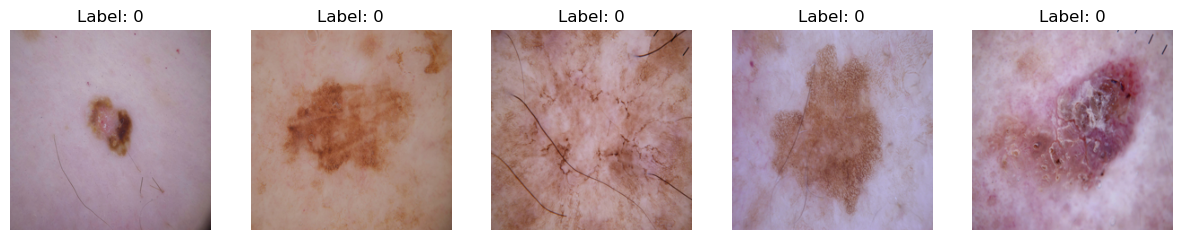

In [30]:
import matplotlib.pyplot as plt

# Display sample images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {np.argmax(y_train[i])}")
    ax.axis('off')
plt.show()


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build CNN (conv neural network) Model
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the model
input_shape = (224, 224, 3) 
num_classes = len(np.unique(y))  

cnn_model = build_cnn_model(input_shape, num_classes)

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# View the model summary
cnn_model.summary()


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 128,964,930 (491.96 MB)

 Trainable params: 128,961,986 (491.95 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [34]:
#Training our CNN Model
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 460s 9s/step - accuracy: 0.9978 - loss: 16213.8096 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 445s 9s/step - accuracy: 0.9991 - loss: 1585.6995 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 460s 9s/step - accuracy: 0.9829 - loss: 1448.8949 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 438s 9s/step - accuracy: 0.9993 - loss: 109.8436 - val_accuracy: 1.0000 - val_loss: 4.3273e-04
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 436s 9s/step - accuracy: 0.9630 - loss: 2422.7251 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 413s 8s/step - accuracy: 0.9962 - loss: 1930.5531 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 465s 9s/step - accuracy: 0.9750 - loss: 372.0815 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 440s 9s/step - accuracy: 

In [35]:
train_score = cnn_model.evaluate(X_train, y_train, verbose=1)
test_score = cnn_model.evaluate(X_test, y_test, verbose=1)
print("Train Loss:", train_score[0])
print("Train Accuracy:", train_score[1])
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])


26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9997 - loss: 0.0659
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00
Train Loss: 0.28104543685913086
Train Accuracy: 0.9987684488296509
Test Loss: 0.0
Test Accuracy: 1.0


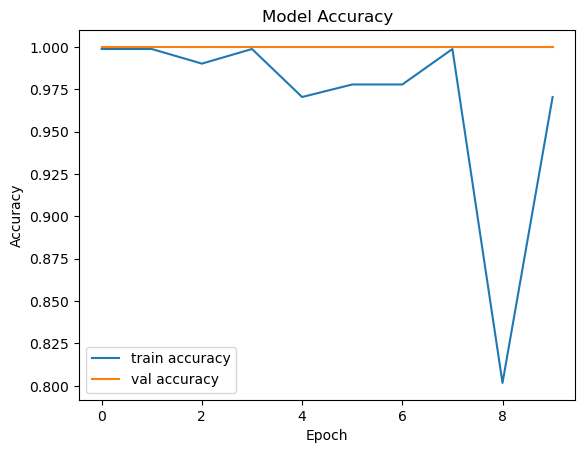

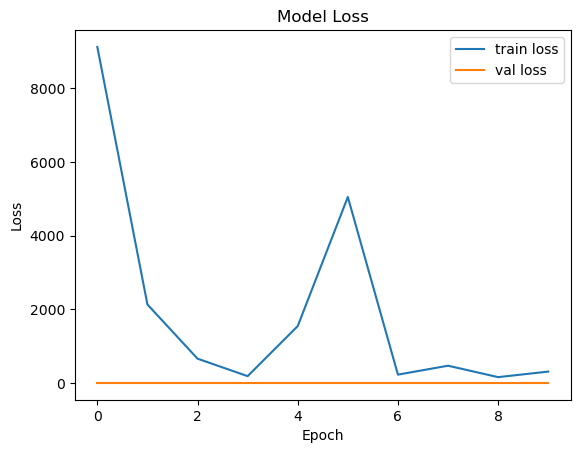

In [37]:
# Plot training history
def plot_training_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_training_history(history)